In [1]:
from multi_imbalance.datasets import load_datasets
from utils import plot_embeddings, calc_embeddings
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from utils import TripletCleveland, TripletLoss, TripletLossWeighted
import matplotlib.pyplot as plt

/home/dhorna/anaconda3/envs/mgr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
dataset = load_datasets()['cleveland']

In [3]:
X, y = dataset.data, dataset.target
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
print(X[:5])
print(y[:5])

[[ 0.94872647  0.68620244 -2.25177456  0.75752504 -0.2649003   2.394438
   1.01668424  0.01719733 -0.69663055  1.08733806  2.27457861 -0.71843085
   0.65446526]
 [ 1.39200191  0.68620244  0.87798549  1.61121989  0.76041519 -0.41763453
   1.01668424 -1.82190531  1.43548113  0.39718162  0.64911323  2.50557013
  -0.89812044]
 [ 1.39200191  0.68620244  0.87798549 -0.6652997  -0.34228261 -0.41763453
   1.01668424 -0.90235399  1.43548113  1.34614673  0.64911323  1.43090314
   1.17199382]
 [-1.93256387  0.68620244 -0.16526786 -0.0961698   0.06397448 -0.41763453
  -0.99674925  1.63735918 -0.69663055  2.12257273  2.27457861 -0.71843085
  -0.89812044]
 [-1.48928843 -1.4572959  -1.20852121 -0.0961698  -0.82592199 -0.41763453
   1.01668424  0.98053681 -0.69663055  0.31091206 -0.97635214 -0.71843085
  -0.89812044]]
[0 2 1 0 0]


In [4]:
from collections import Counter
cards = Counter(y_train)
weights = {c: (1/v) * 100 for c,v in cards.items()}

In [5]:
weights

{1: 2.4390243902439024,
 0: 0.8130081300813009,
 2: 3.7037037037037033,
 4: 10.0,
 3: 3.8461538461538463}

In [6]:
y_train.shape

(227,)

### PCA visualization

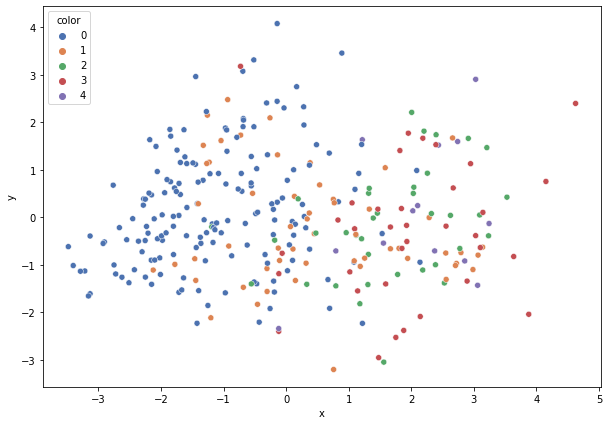

In [7]:
X_embedded = PCA(n_components=2).fit_transform(X)
plot_embeddings(X_embedded, y)

In [8]:
class Print(nn.Module):
    def __init__(self):
        super(Print, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x

class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.fc = nn.Sequential(nn.Linear(13, 64),
                                nn.PReLU(),
                                nn.Linear(64, 32),
                                nn.PReLU(),
                                nn.Linear(32, 2)
                                )

    def forward(self, x):
        output = self.fc(x)
        return output
    
    def embed(self, x):
        return self.forward(x)
    

class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.nonlinear = nn.PReLU()
        self.fc1 = nn.Linear(2, n_classes)

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        scores = F.log_softmax(self.fc1(output), dim=-1)
        return scores
    
    def embed(self,x):
        return self.embedding_net(x)
    
    
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
        return output1, output2, output3
    
    def embed(self, x):
        return self.embedding_net(x)

In [12]:
def train_tripletnet(model, device, train_loader, optimizer, epoch, log_interval = 10, dry_run=False):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target_weights = []
        for t in target[0]:
            target_weights.append(weights[t.item()])
#         print(target_weights)
        data[0] = torch.reshape(data[0], (data[0].shape[0],13))
        data[1] = torch.reshape(data[1], (data[0].shape[0],13))
        data[2] = torch.reshape(data[2], (data[0].shape[0],13))
        data = tuple(d.cuda() for d in data)
        
        optimizer.zero_grad()        
        outputs = model(*data)
        loss_inputs = outputs
        w = torch.Tensor(np.array(target_weights)).to(device)
        loss_fn = TripletLoss(margin=1.0)
        
        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test_tripletnet(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data[0] = torch.reshape(data[0], (data[0].shape[0],13))
            data[1] = torch.reshape(data[1], (data[0].shape[0],13))
            data[2] = torch.reshape(data[2], (data[0].shape[0],13))
            data = tuple(d.cuda() for d in data)
            
            outputs = model(*data)

            loss_inputs = outputs
            loss_fn = TripletLoss(1.0)

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            test_loss += loss.item()

    test_loss

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))

In [13]:
seed = 7
batch_size = 32
test_batch_size = 32
use_cuda = True
lr = 1e-3
gamma = 0.9
epochs = 50
save_model = True
log_interval = 20

torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda: 
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)


dataset1 = TensorDataset(torch.Tensor(X_train),torch.Tensor(y_train))
dataset1.train_data = torch.Tensor(X_train)
dataset1.train_labels = torch.Tensor(y_train)
dataset1.train = True

dataset2 = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
dataset2.test_data = torch.Tensor(X_test)
dataset2.test_labels = torch.Tensor(y_test)
dataset2.train = False

triplet_train_dataset = TripletCleveland(dataset1)
triplet_test_dataset = TripletCleveland(dataset2)

triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, **train_kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, **test_kwargs)

embedding_net = EmbeddingNet()
model = TripletNet(embedding_net).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in range(1, epochs + 1):
    train_tripletnet(model, device, triplet_train_loader, optimizer, epoch, log_interval)
    test_tripletnet(model, device, triplet_test_loader)
    scheduler.step()

if save_model:
    torch.save(model.state_dict(), "mnist_cnn_triplet.pt")

Train Epoch: 1 [0/227 (0%)]	Loss: 0.971984

Test set: Average loss: 2.8134

Train Epoch: 2 [0/227 (0%)]	Loss: 0.938053

Test set: Average loss: 2.4032

Train Epoch: 3 [0/227 (0%)]	Loss: 0.882017

Test set: Average loss: 2.2042

Train Epoch: 4 [0/227 (0%)]	Loss: 0.714693

Test set: Average loss: 1.8847

Train Epoch: 5 [0/227 (0%)]	Loss: 0.638782

Test set: Average loss: 1.9889

Train Epoch: 6 [0/227 (0%)]	Loss: 0.503607

Test set: Average loss: 1.8869

Train Epoch: 7 [0/227 (0%)]	Loss: 0.697078

Test set: Average loss: 1.9461

Train Epoch: 8 [0/227 (0%)]	Loss: 0.652169

Test set: Average loss: 1.7387

Train Epoch: 9 [0/227 (0%)]	Loss: 0.529108

Test set: Average loss: 1.9272

Train Epoch: 10 [0/227 (0%)]	Loss: 0.580051

Test set: Average loss: 1.7728

Train Epoch: 11 [0/227 (0%)]	Loss: 0.442450

Test set: Average loss: 1.9831

Train Epoch: 12 [0/227 (0%)]	Loss: 0.673447

Test set: Average loss: 2.0045

Train Epoch: 13 [0/227 (0%)]	Loss: 0.665617

Test set: Average loss: 1.7855

Train Ep

100%|██████████| 76/76 [00:00<00:00, 2916.34it/s]


Text(0.5, 1.0, 'Test embeddings')

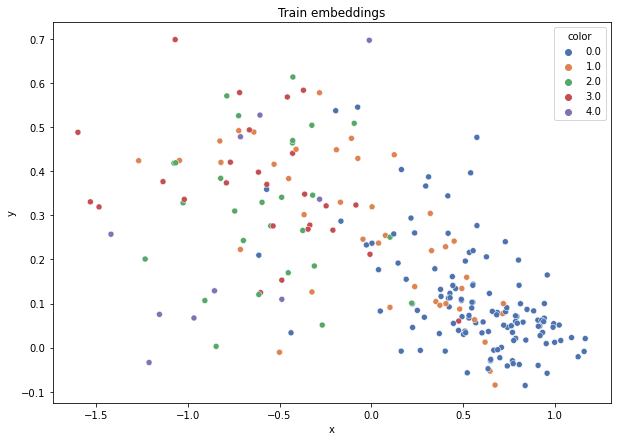

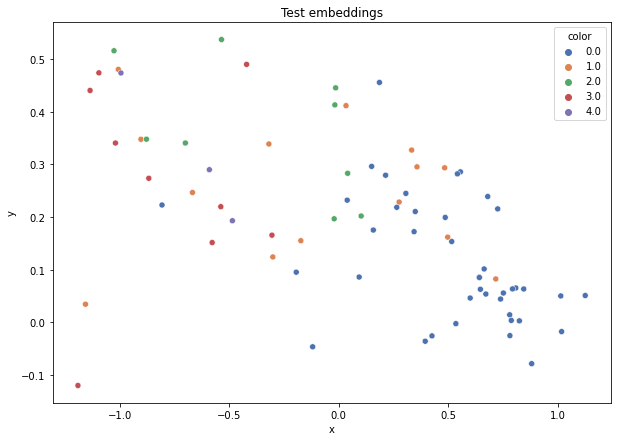

In [14]:
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=1)

embeddings_train, labels = calc_embeddings(model, device, train_loader)
plot_embeddings(embeddings_train, labels)
plt.title("Train embeddings")

embeddings_test, labels = calc_embeddings(model, device, test_loader)
plot_embeddings(embeddings_test, labels)
plt.title("Test embeddings")

klasyfikator

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from multi_imbalance.utils.metrics import gmean_score
from sklearn.metrics import f1_score
import pandas as pd

In [19]:
result_dict = {
    "depth": [],
    "old f1": [],
    "new f1": [],
    "old gmean": [],
    "new gmean": []
}


for depth in [2,3,4,5,6,7,8]:
    result_dict["depth"].append(depth)
    clf = RandomForestClassifier(max_depth=depth, random_state=0)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)

#     print(classification_report(y_test, preds))
    gmean = gmean_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='macro')
    result_dict["old f1"].append(f1)
    result_dict["old gmean"].append(gmean)

    X_train_new = np.hstack([X_train, embeddings_train])
    X_test_new = np.hstack([X_test, embeddings_test])

    clf = RandomForestClassifier(max_depth=depth, random_state=0)
    clf.fit(X_train_new, y_train)
    preds = clf.predict(X_test_new)

#     print(classification_report(y_test, preds))
    gmean = gmean_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='macro')
    result_dict["new f1"].append(f1)
    result_dict["new gmean"].append(gmean)
    
pd.DataFrame.from_dict(result_dict)

,depth,old f1,new f1,old gmean,new gmean
0,2,0.178519,0.212885,0.010213,0.026200
1,3,0.176863,0.191667,0.010163,0.010163
2,4,0.213283,0.197442,0.026071,0.010163
3,5,0.206667,0.250607,0.023866,0.031491
4,6,0.239575,0.232191,0.029731,0.027276
5,7,0.193742,0.212222,0.010163,0.023746
6,8,0.223418,0.269863,0.027135,0.075885
